In [1]:
%config InlineBackend.figure_format = 'retina'

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt

# Set up directories

In [3]:
from pathlib import Path
data_root = Path.home() / "data" / "tmp"
sample_dir = data_root / "cats_vs_dogs_sample"

# Use an existing deep learning model for feature extraction

## Create model

In [4]:
from keras.applications import VGG16

conv_base = VGG16(weights='imagenet', include_top=False, input_shape=(150, 150, 3))

Using TensorFlow backend.


## Adding a densely connected classifier on top of the convolutional base

In [5]:
from keras import models
from keras import layers

model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

In [6]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               2097408   
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 257       
Total params: 16,812,353
Trainable params: 16,812,353
Non-trainable params: 0
_________________________________________________________________


### Freeze conv base layers

In [7]:
print('This is the number of trainable weights '
      'before freezing the conv base:', len(model.trainable_weights))
conv_base.trainable = False
print('This is the number of trainable weights '
      'after freezing the conv base:', len(model.trainable_weights))

This is the number of trainable weights before freezing the conv base: 30
This is the number of trainable weights after freezing the conv base: 4


### compile model

In [8]:
from keras import optimizers

model.compile(
    loss='binary_crossentropy',
    optimizer=optimizers.RMSprop(lr=2e-5),
    metrics=['acc'])

## Create training data generator

In [9]:
from keras.preprocessing.image import ImageDataGenerator

In [10]:
train_datagen = ImageDataGenerator(
      rescale=1./255,
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        str(sample_dir / "train"),
        target_size=(150, 150),
        batch_size=20,
        class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
        str(sample_dir / "validation"),
        target_size=(150, 150),
        batch_size=20,
        class_mode='binary')

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


## Fit model

In [12]:
%%time
history = model.fit_generator(
      train_generator,
      steps_per_epoch=100,
      epochs=30,
      validation_data=validation_generator,
      validation_steps=50)

Epoch 1/30
100/100 [==============================] - 24s 244ms/step - loss: 0.4082 - acc: 0.8195 - val_loss: 0.3056 - val_acc: 0.8820
Epoch 2/30
100/100 [==============================] - 23s 230ms/step - loss: 0.3797 - acc: 0.8315 - val_loss: 0.2879 - val_acc: 0.8850
Epoch 3/30
100/100 [==============================] - 23s 231ms/step - loss: 0.3697 - acc: 0.8395 - val_loss: 0.2773 - val_acc: 0.8950
Epoch 4/30
100/100 [==============================] - 23s 230ms/step - loss: 0.3571 - acc: 0.8360 - val_loss: 0.2709 - val_acc: 0.8910
Epoch 5/30
100/100 [==============================] - 23s 230ms/step - loss: 0.3505 - acc: 0.8440 - val_loss: 0.2676 - val_acc: 0.8860
Epoch 6/30
100/100 [==============================] - 23s 229ms/step - loss: 0.3316 - acc: 0.8545 - val_loss: 0.2581 - val_acc: 0.8950
Epoch 7/30
100/100 [==============================] - 23s 230ms/step - loss: 0.3442 - acc: 0.8505 - val_loss: 0.2554 - val_acc: 0.9030
Epoch 8/30
100/100 [==============================] - 2

In [13]:
import json

models_dir = data_root / "models" 
models_dir.mkdir(exist_ok=True)
model.save(str(models_dir / "cats_and_dogs_feature_extraction2.h5"))

history_path = models_dir / "cats_and_dogs_feature_extraction2_history.json"
with open(str(history_path), "w") as f:
    json.dump(history.history, f)

In [14]:
history = json.load(open(str(history_path)))

## Plot training vs test accuracy

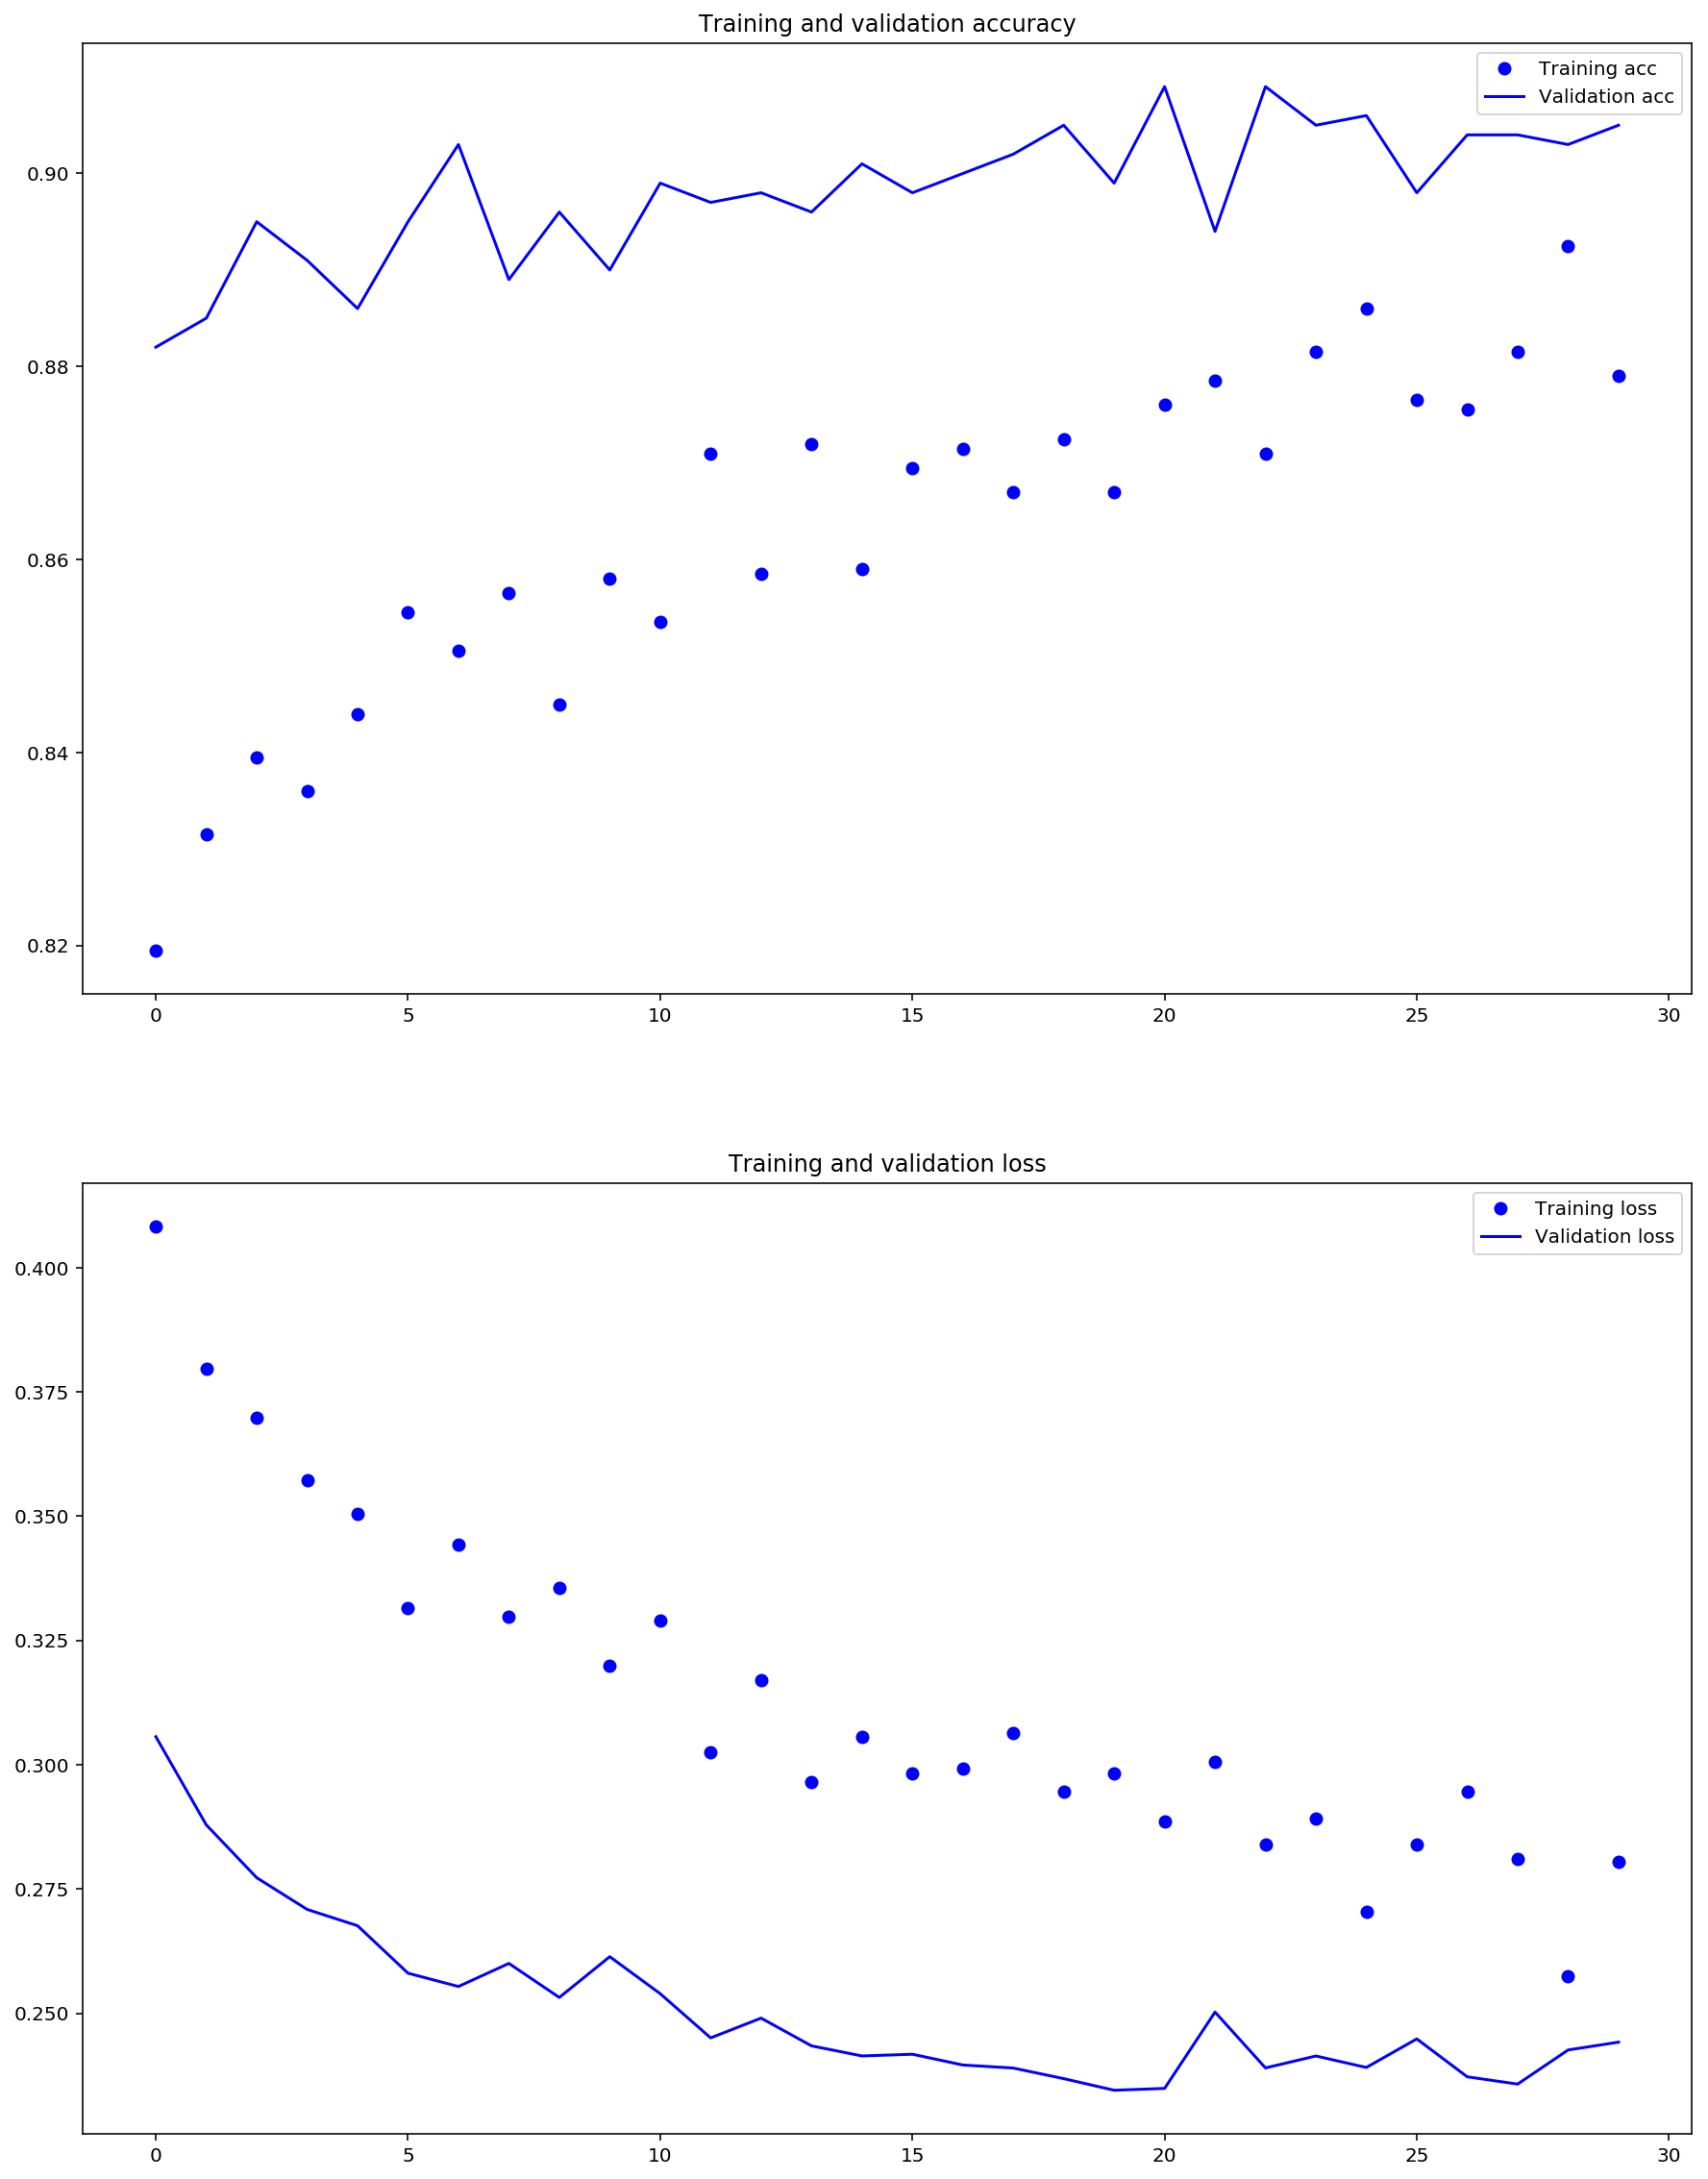

In [15]:
import matplotlib.pyplot as plt

acc = history['acc']
val_acc = history['val_acc']
loss = history['loss']
val_loss = history['val_loss']

epochs = range(len(acc))

plt.figure(figsize=(15, 20))

plt.subplot(211)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.subplot(212)

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

# Unfreezing some of the layers

In [16]:
conv_base.trainable = True
set_trainable = False

for layer in conv_base.layers:
    if layer.name == "block5_conv1":
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

In [17]:
model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-5),
              metrics=['acc'])

In [18]:
%%time
history = model.fit_generator(
      train_generator,
      steps_per_epoch=100,
      epochs=100,
      validation_data=validation_generator,
      validation_steps=50)

Epoch 1/100
100/100 [==============================] - 25s 248ms/step - loss: 0.3000 - acc: 0.8720 - val_loss: 0.2376 - val_acc: 0.9060
Epoch 2/100
100/100 [==============================] - 23s 232ms/step - loss: 0.2464 - acc: 0.8950 - val_loss: 0.3071 - val_acc: 0.8870
Epoch 3/100
100/100 [==============================] - 23s 231ms/step - loss: 0.2403 - acc: 0.8980 - val_loss: 0.2026 - val_acc: 0.9160
Epoch 4/100
100/100 [==============================] - 23s 230ms/step - loss: 0.2245 - acc: 0.9015 - val_loss: 0.1928 - val_acc: 0.9230
Epoch 5/100
100/100 [==============================] - 23s 230ms/step - loss: 0.2008 - acc: 0.9175 - val_loss: 0.1935 - val_acc: 0.9250
Epoch 6/100
100/100 [==============================] - 23s 229ms/step - loss: 0.1685 - acc: 0.9255 - val_loss: 0.2058 - val_acc: 0.9170
Epoch 7/100
100/100 [==============================] - 23s 229ms/step - loss: 0.1735 - acc: 0.9325 - val_loss: 0.1991 - val_acc: 0.9200
Epoch 8/100
100/100 [===========================

Epoch 61/100
100/100 [==============================] - 23s 230ms/step - loss: 0.0347 - acc: 0.9870 - val_loss: 0.2852 - val_acc: 0.9350
Epoch 62/100
100/100 [==============================] - 23s 230ms/step - loss: 0.0291 - acc: 0.9895 - val_loss: 0.2375 - val_acc: 0.9440
Epoch 63/100
100/100 [==============================] - 23s 232ms/step - loss: 0.0402 - acc: 0.9870 - val_loss: 0.2985 - val_acc: 0.9300
Epoch 64/100
100/100 [==============================] - 23s 233ms/step - loss: 0.0263 - acc: 0.9880 - val_loss: 0.2512 - val_acc: 0.9390
Epoch 65/100
100/100 [==============================] - 23s 230ms/step - loss: 0.0287 - acc: 0.9915 - val_loss: 0.2841 - val_acc: 0.9270
Epoch 66/100
100/100 [==============================] - 23s 232ms/step - loss: 0.0385 - acc: 0.9880 - val_loss: 0.2415 - val_acc: 0.9370
Epoch 67/100
100/100 [==============================] - 23s 232ms/step - loss: 0.0274 - acc: 0.9905 - val_loss: 0.2677 - val_acc: 0.9400
Epoch 68/100
100/100 [===================

In [19]:
import json

models_dir = data_root / "models" 
models_dir.mkdir(exist_ok=True)
model.save(models_dir / "cats_and_dogs_fine_tuning.h5")

history_path = models_dir / "cats_and_dogs_fine_tuning_history.json"
with open(str(history_path), "w") as f:
    json.dump(history.history, f)

In [20]:
history = json.load(open(str(history_path)))

# Plot training vs test accuracy

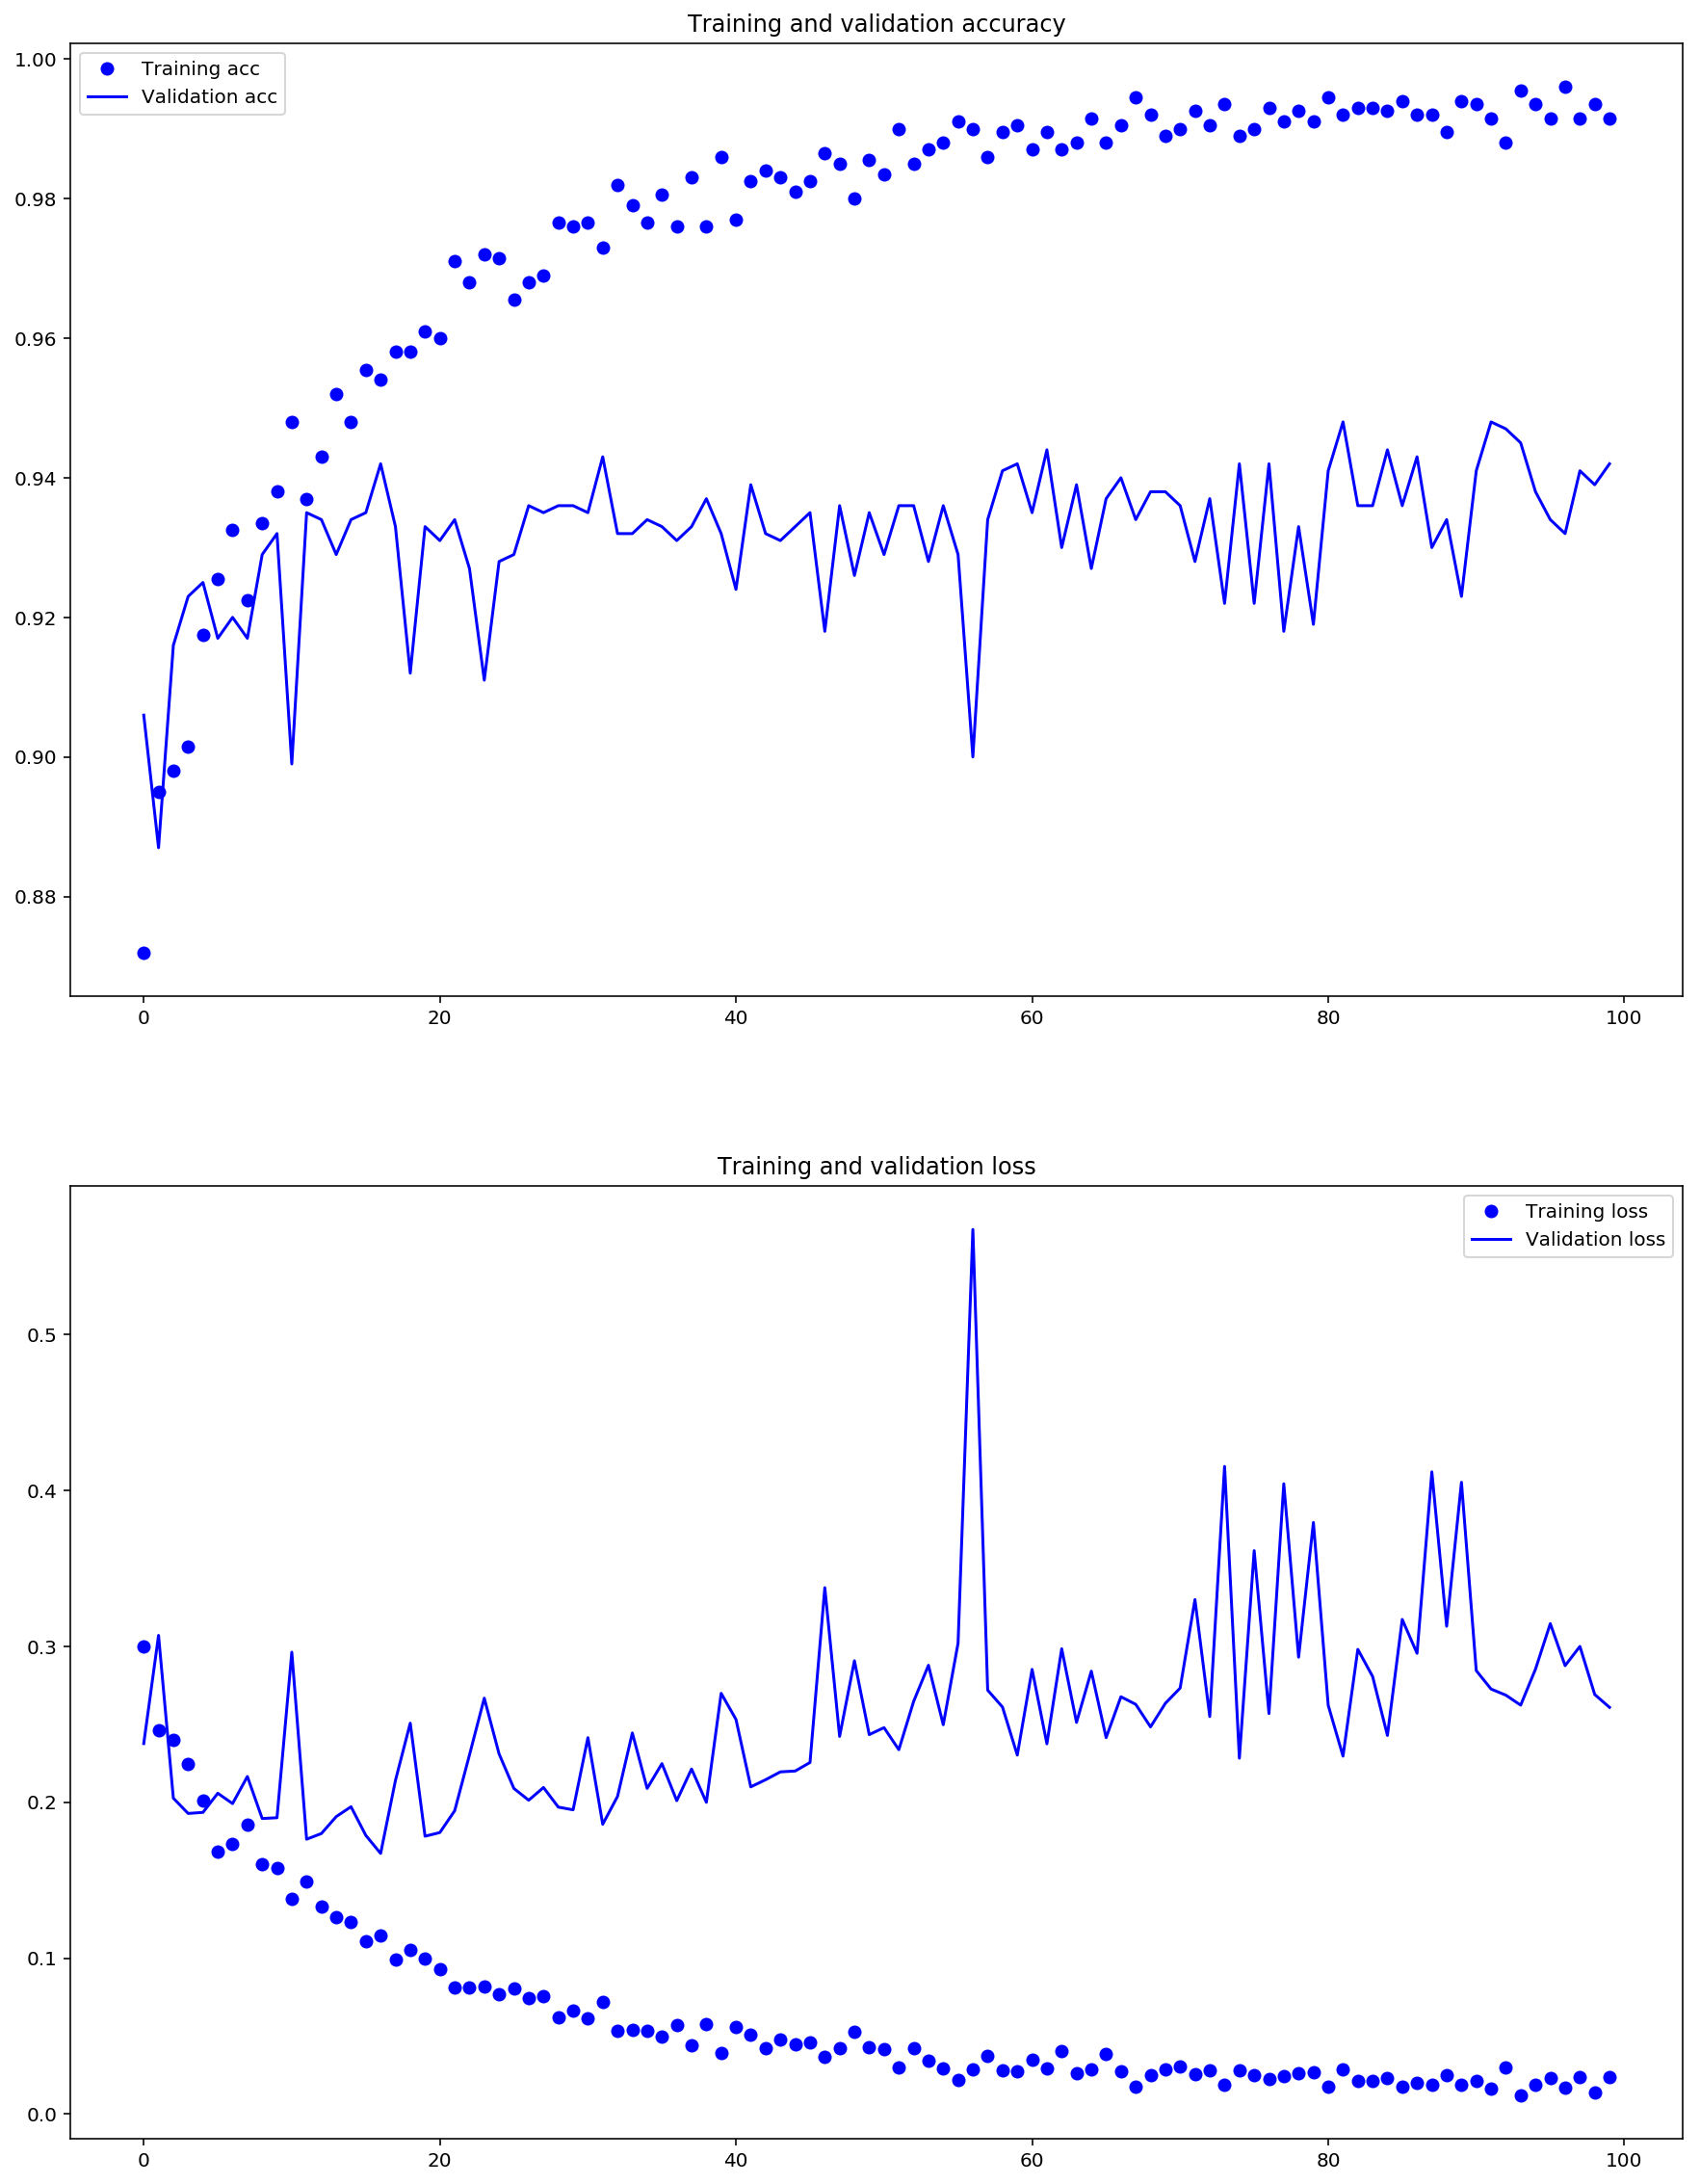

In [21]:
import matplotlib.pyplot as plt

acc = history['acc']
val_acc = history['val_acc']
loss = history['loss']
val_loss = history['val_loss']

epochs = range(len(acc))

plt.figure(figsize=(15, 20))

plt.subplot(211)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.subplot(212)

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

# Evaluate model on test data

In [23]:
test_generator = test_datagen.flow_from_directory(
        str(sample_dir / "test"),
        target_size=(150, 150),
        batch_size=20,
        class_mode='binary')

test_loss, test_acc = model.evaluate_generator(test_generator, steps=50)
print('test acc:', test_acc)

Found 1000 images belonging to 2 classes.
test acc: 0.9369999957084656
